In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch
import random

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Define Paramaters

In [2]:
base_seed = 42
base_feature_size = 18
baseline_accuracy = 0.875

np.random.seed(base_seed)
random.seed(base_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [4]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [100],
    'batch_size': [2048],
    'module__layer_size': [64, 128],
    'module__layer_no': [1, 2],
    'optimizer__weight_decay': [1e-3, 1e-2],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [5]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 2048, 'max_epochs': 100, 'module__layer_no': 1, 'module__layer_size': 64, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9601041666666668


### Assesing performance

In [6]:
nn_results, unscaled_guarantee = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9568055555555556
Run 2 / 10 started
Run finished with test accuracy: 0.9576388888888889
Run 3 / 10 started
Run finished with test accuracy: 0.9555555555555556
Run 4 / 10 started
Run finished with test accuracy: 0.9533333333333334
Run 5 / 10 started
Run finished with test accuracy: 0.9527777777777777
Run 6 / 10 started
Run finished with test accuracy: 0.9652777777777778
Run 7 / 10 started
Run finished with test accuracy: 0.9551388888888889
Run 8 / 10 started
Run finished with test accuracy: 0.9530555555555555
Run 9 / 10 started
Run finished with test accuracy: 0.9593055555555555
Run 10 / 10 started
Run finished with test accuracy: 0.9522222222222222


In [7]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.694026        0.494896       0.956806
1     0      1    0.693109        0.505556       0.956806
2     0      2    0.693065        0.504618       0.956806
3     0      3    0.693038        0.508056       0.956806
4     0      4    0.693043        0.507257       0.956806


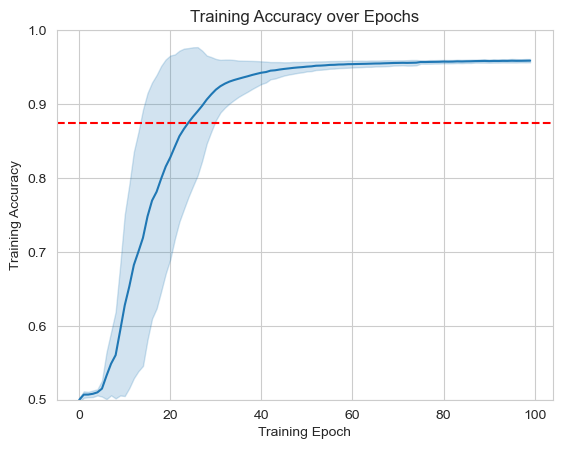

In [8]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

In [9]:
risk_tolerance = nn_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.08111111111111113) <= 0.00


# Random Forrests

In [9]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

MemoryError: Unable to allocate 28.9 GiB for an array with shape (28800, 134596) and data type float64

### Assessing Performance

In [6]:
forrest_results, unscaled_guarantee = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started


MemoryError: Unable to allocate 28.9 GiB for an array with shape (28800, 134596) and data type float64

In [ ]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.970972
1    1       0.973056
2    2       0.970139
3    3       0.969028
4    4       0.971667
5    5       0.970972
6    6       0.973194
7    7       0.971250
8    8       0.970694
9    9       0.969167


In [ ]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9710138888888888
Baseline to beat 0.875


In [ ]:
risk_tolerance = forrest_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  